### STAT 4185 Final Project
### Jacob Gratrix

## An Analysis of the US Power Grid and its System Optimality

### Introduction

The United States power grid, while commercially balkanized among regional markets and operating firms, is the largest and most connected piece of infrastructure ever constructed by mankind. While the relationships between consumer satisfaction with grid operations and the actual upkeep status of the grid are no doubt complex, here we aim to ascertain the rough degree to which this infrastructure accomplishes its explicit goal. That is to provide electricity from where it is supplied to where it is demanded.



## Data Collection

We first import the relevant libraries for performing our analysis.

In [217]:
import sys
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

We also import several libraries for the data collection. These include the builtin `datetime` package and the `gridstatus` API for collating data from regional power operators.

In [67]:
import gridstatus as gs
import datetime as dt

import urllib
from bs4 import BeautifulSoup as bs
import requests

import re

Next it is necessary to define a list of service operators, `interconnections`, for convenience of analysing multiple regions at once. 
Additionally, we define two functions, `get_fuel_mixes` and `get_grid_loads` to return Pandas DataFrames amenable to processing.

We will use data from the current year, from a subset of the months of the year, and include data from just the first day of the month in order to keep the data volume manageable. 

Note that `interconnections` will not include the PJM, MISO, SPP, or Ercot regional system operators. This is because they either have no published fuel mix data for the dates requested, or don't support the fuel mix retrieval method in the `gridstatus` module. 

In [9]:
isone = gs.ISONE() # New England ISO
caiso = gs.CAISO() # California ISO
nyiso = gs.NYISO() # New York ISO
pjm = gs.PJM() # PJM Interconnection RTO
miso = gs.MISO() # Midcontinent ISO
spp = gs.SPP() # Southwest Power Pool RTO
ercot = gs.Ercot() # Electric Reliability Council, Texas

interconnections = [isone, caiso, nyiso] # Excluded: PJM, MISO, SPP, Ercot

months = ['January', 'March', 'May', 'July', 'September', 'November'] # We include odd months

def get_fuel_mixes(iso):
    fuel_mixes = {}
    for mo in months:
        start = pd.Timestamp(f'{mo} 1, 2022')
        end = pd.Timestamp(f'{mo} 2, 2022') # We'll only use one day each month to keep amt of data manageable
        fuel_mix = iso.get_fuel_mix(start, verbose=False)
        fuel_mixes[mo] = fuel_mix
    return fuel_mixes

def get_grid_loads(iso):
    grid_loads = {}
    for mo in months:
        start = pd.Timestamp(f'{mo} 1, 2022')
        end = pd.Timestamp(f'{mo} 2, 2022') # We'll only use one day each month to keep amt of data manageable
        grid_load = iso.get_load(start)
        grid_loads[mo] = grid_load
    return grid_loads

Using these functions, we obtain our fuel mix data and grid load data for the first day in the first odd months of 2022. 
Please note that the following cell takes upwards of 90 seconds to run. As an alternative, proceeding the following two cells, a script will generate the relevant Pandas dataframes given that the `./data` folder and `.csv` data files are present in your directory. 

In [10]:
%%capture --no-display

mix_dfs = {}
load_dfs = {}

for iso in interconnections:
    mix_dfs[iso] = get_fuel_mixes(iso)
    load_dfs[iso] = get_grid_loads(iso)


In [30]:
for iso in interconnections:
    for mo in months:
        mix_output = pd.DataFrame(mix_dfs[iso][mo])
        mix_output.to_csv(path_or_buf=f'./data/mix-{repr(iso)[12:16]}-{mo}', index=False)
        load_output = pd.DataFrame(load_dfs[iso][mo])
        load_output.to_csv(path_or_buf=f'./data/load-{repr(iso)[12:16]}-{mo}', index=False)


The following cell may be used if the `./data` folder is accessible in your directory to generate the relevant Pandas dataframes. 

In [35]:
mix_dfs = {}
load_dfs = {}

for iso in interconnections:
    iso_str = repr(iso)[12:16]
    mix_dfs[iso] = {}
    load_dfs[iso] = {}
    for mo in months:
        mix_dfs[iso][mo] = pd.read_csv(f'./data/mix-{iso_str}-{mo}')
        load_dfs[iso][mo] = pd.read_csv(f'./data/load-{iso_str}-{mo}')


Last we incorporate data on US power consumption by state and/or region in the current year, where we will perform the proper grouping and data munging tasks later on. 

In [68]:
url = 'https://www.eia.gov/electricity/state/'
req = requests.get(url)
assert (req.status_code == 200)

In [103]:
content = bs(req.content, 'html.parser')
sel_tab = content.select('td')

selection = [str(a) for a in sel_tab]


## Data Cleaning and Munging

Next we aim to transform these Pandas dataframes in order to make them amenable to statistical modeling. First we will check the datatypes of each series. 

In [59]:
print(mix_dfs[isone]['January'].dtypes)
print(load_dfs[isone]['January'].dtypes)

mix_dfs[isone]['January'].head()
#load_dfs[isone]['January'].head()




Time             object
Hydro           float64
Landfill Gas    float64
Natural Gas     float64
Nuclear         float64
Other           float64
Refuse          float64
Solar           float64
Wind            float64
Wood            float64
dtype: object
Time     object
Load    float64
dtype: object


,Time,Hydro,Landfill Gas,Natural Gas,Nuclear,Other,Refuse,Solar,Wind,Wood
0,2022-01-01 00:01:02-05:00,546.0,39.0,4053.0,3352.0,0.0,376.0,3.0,78.0,242.0
1,2022-01-01 00:23:37-05:00,554.0,39.0,3625.0,3353.0,0.0,369.0,3.0,93.0,244.0
2,2022-01-01 00:47:42-05:00,554.0,39.0,3377.0,3351.0,0.0,380.0,3.0,85.0,243.0
3,2022-01-01 01:02:14-05:00,546.0,39.0,3162.0,3352.0,13.0,380.0,3.0,93.0,244.0
4,2022-01-01 01:23:20-05:00,537.0,39.0,3078.0,3350.0,35.0,378.0,3.0,100.0,242.0


We convert the data type of the `Time` series to Pandas `datetime64`, and remedy any missing values. 

In [60]:
for iso in interconnections:
    for mo in months:
        mix_dfs[iso][mo]['Time'][:10].astype('datetime64')
        load_dfs[iso][mo]['Time'][:10].astype('datetime64')
        

Lastly we need to clean and subset the US consumption data contained in our data structure `selection`.

In [177]:
states = []
avg_price = []
net_sum_cap = []
net_gen = []
retail_sales = []

i = 0
for s in selection[:]:
    if i % 5 == 0:
        states.append(re.findall(r'"(.*?)"', s))
    elif i % 5 == 1:
        avg_price.append(re.findall(r'[\d,]+\.\d+', s))
    elif i % 5 == 2:
        net_sum_cap.append(re.findall(r'[\d,]+\d+', s))
    elif i % 5 == 3:
        net_gen.append(re.findall(r'[\d,]+\d+', s))
    elif i % 5 == 4:
        retail_sales.append(re.findall(r'[\d,]+\d+', s))
    i += 1

for i in [states, avg_price, net_sum_cap, net_gen, retail_sales]:
    for j in range(len(i)):
        i[j] = str(i[j][0]).strip()

states = pd.Series(states, dtype='str')
avg_price = pd.Series(avg_price, dtype='float64')
net_sum_cap = pd.Series(net_sum_cap).apply(lambda x: x.replace(',', '')).astype(np.float64)
net_gen = pd.Series(net_gen).apply(lambda x: x.replace(',', '')).astype(np.float64)
retail_sales = pd.Series(retail_sales).apply(lambda x: x.replace(',', '')).astype(np.float64)

consumption = pd.DataFrame([states, avg_price, net_sum_cap, net_gen, retail_sales]).transpose()
consumption.columns = ['State', 'Avg Price (cent/kWh)', 'Net Summer Capcity (MW)', 'Net Generation (MWh)', 'Total Retail Sales (MWh)']

consumption.head()

,State,Avg Price (cent/kWh),Net Summer Capcity (MW),Net Generation (MWh),Total Retail Sales (MWh)
0,alabama,10.18,28911.0,142733330.0,85585166.0
1,alaska,20.02,2774.0,6595818.0,5969339.0
2,arizona,10.73,27596.0,108604620.0,81219990.0
3,arkansas,9.1,14832.0,61100068.0,48663142.0
4,california,19.65,81184.0,197165106.0,247249865.0


Now we introduce the relevant grouping according to ISO service areas.

In [181]:
iso_st = {'connecticut': 'ISONE', 
'massachusetts': 'ISONE', 
'rhodeisland': 'ISONE', 
'maine': 'ISONE', 
'newhampshire': 'ISONE', 
'vermont': 'ISONE', 
'newyork': 'NYISO', 
'california': 'CAISO', 
'nevada': 'CAISO'}

iso_states = pd.Series([iso_st.get(st) for st in consumption['State']])

consumption['State ISO'] = iso_states

For reference and reproducibility, the following code creates a `.csv` file for this consumption dataframe, and then generates a dataframe from that `.csv` file.

In [183]:
consumption.to_csv(path_or_buf=f'./data/US-Power-Consumption-and-Prices', index=False)

In [ ]:
consumption = pd.read_csv(f'./data/US-Power-Consumption-and-Prices')

## A Few Visualizations

We would first like to chart the difference is mixes of fuels used to power the New England, Newq York, and California repectively. 

In [238]:
%%capture --no-display

isos = [isone, nyiso, caiso]
month = 'January'

dat = pd.DataFrame()
for iso in isos:
    dat[iso] = mix_dfs[iso][month].mean()

dat.columns = ['ISONE', 'NYISO', 'CAISO']
dat.fillna(0.0, inplace=True)
dat = dat.transpose()
source_ls = list(dat.columns)


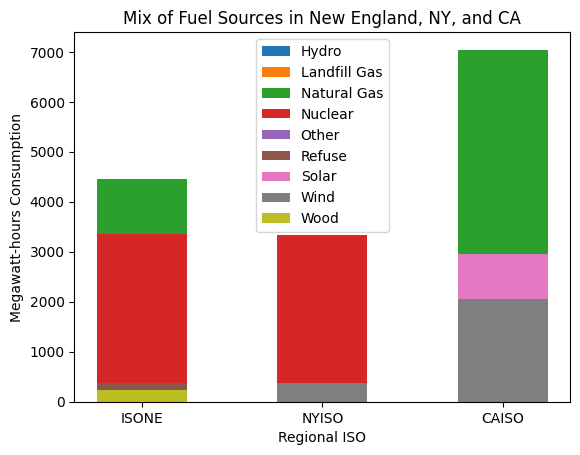

In [237]:
fig, ax = plt.subplots()

for source in source_ls:
    ax.bar(['ISONE', 'NYISO', 'CAISO'], dat[source], width=0.5, label=source)

ax.set_ylabel('Megawatt-hours Consumption')
ax.set_xlabel('Regional ISO')
ax.set_title('Mix of Fuel Sources in New England, NY, and CA')
ax.legend()

plt.show()

## Constructing the Models

## Results and Conclusions